# Mapping salt in 2-D seismic image using a deep convolutional neural network
This tutorial describes how to map salt in a 2-D seismic image using a deep convolutional neural network. To follow this tutorial, you won't need any special hardware, software, data or experience - just a Google account.

## Setup ##

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-1/tutorial-1.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [1]:
# Load packages necessary for this tutorial
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from sklearn.metrics import confusion_matrix

Next we clone the Github repository to get our data:

In [2]:
!git clone https://github.com/thilowrona/seismic_deep_learning

fatal: destination path 'seismic_deep_learning' already exists and is not an empty directory.


Now you can load and plot the seismic image and its mask:

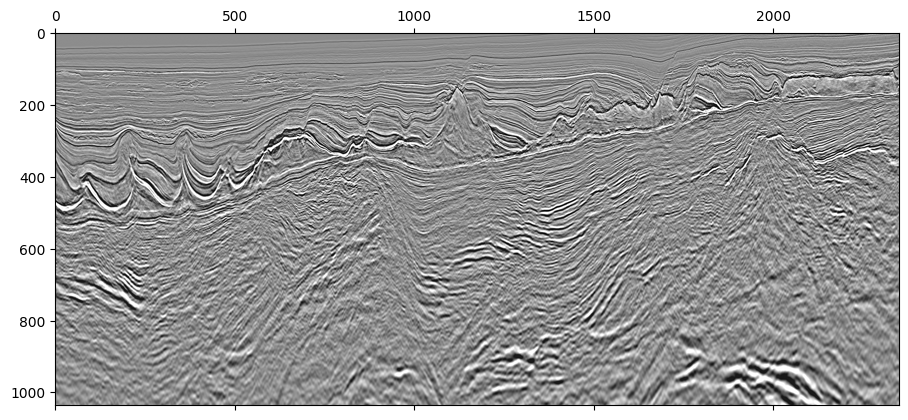

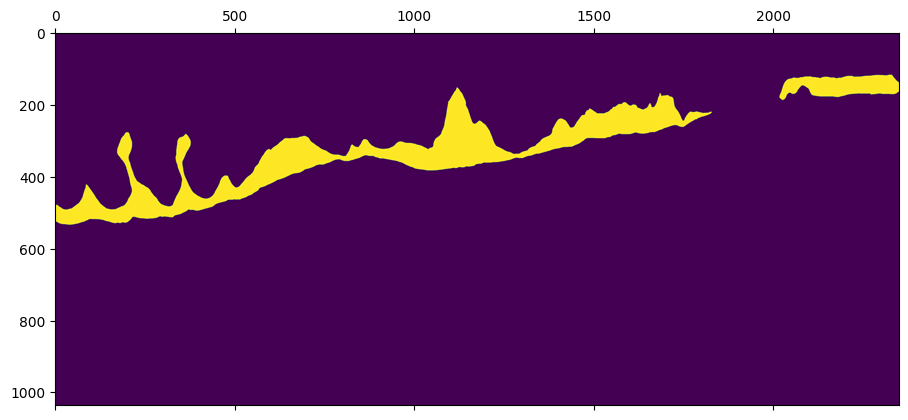

In [3]:
# Load the seismic data image as a NumPy array
# The image is expected to be a grayscale TIFF, possibly with extra channels (e.g., RGBA)
data = mpimg.imread('seismic_deep_learning/tutorial-01/seismic.tif')

# Keep only the first channel (grayscale), normalize pixel values to the range [0, 1]
# This standardization is useful for model input
data = data[:, :, :1] / 255

# Load the corresponding segmentation mask
# The mask image might be in a higher data type, so make a copy to allow modification
mask = mpimg.imread('seismic_deep_learning/tutorial-01/mask.tif').copy()

# Normalize the mask values to the range [0, 1]
# This is useful if the mask has a range like [0, 255] or floating values — makes it compatible with models
mask = (mask - mask.min()) / (mask.max() - mask.min())

# Display the seismic image (grayscale)
plt.matshow(data[:, :, 0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)

# Display the mask in the same way (default colormap if not specified)
plt.matshow(mask, interpolation='spline16', aspect=1)

# Display figure
plt.show()

So now we have one image with a mask, but we need many more examples to train a deep learning model. Of course, we could label more examples, but that takes time and additional data. Let's say we have neither of those. In this case, we can split up our image and mask in to many pairs of small patches. So let's do that:

In [4]:
# Set parameters for training
number_train = 5000           # Number of training patches to extract
number_val   = 1000           # Number of validation patches to extract
dim          = (64, 64, 1)    # Size of each patch: 64x64 pixels, 1 channel (grayscale)

# Function to extract random classification patches from seismic data
def patchify(data, mask, patch_num, dim):
    # Allocate arrays for image patches (X) and their corresponding labels (y)
    X = np.empty((patch_num, *dim))     # Shape: (patch_num, height, width, channels)
    y = np.empty((patch_num, 2))        # Binary class labels in one-hot format: [1,0] or [0,1]

    # Get dimensions of the input seismic data
    t_max, x_max, _ = data.shape

    for n in range(patch_num):
        # Randomly select a center point in the data (avoid the edges so patch fits)
        x_n = random.randint(dim[1] // 2, x_max - dim[1] // 2)
        t_n = random.randint(dim[0] // 2, t_max - dim[0] // 2)

        # Extract a patch centered at the selected point
        X[n, :, :, 0] = data[t_n - dim[0] // 2 : t_n + dim[0] // 2,
                             x_n - dim[1] // 2 : x_n + dim[1] // 2, 0]

        # Determine label at the center pixel from the mask
        # One-hot encode: if salt (1), then [1, 0]; if no salt (0), then [0, 1]
        y[n, 0] = mask[t_n, x_n]           # First column = salt presence (1 or 0)
        y[n, 1] = 1 - mask[t_n, x_n]       # Second column = no salt (1 or 0)

    return X, y

# Generate training patches from the left side of the image
X_train, y_train = patchify(data[:, :1200], mask[:, :1200], number_train, dim)

# Generate validation patches from the right side of the image
X_val, y_val = patchify(data[:, 1200:], mask[:, 1200:], number_val, dim)


Before training, it's always a good idea to look at the training data, so let's do that:

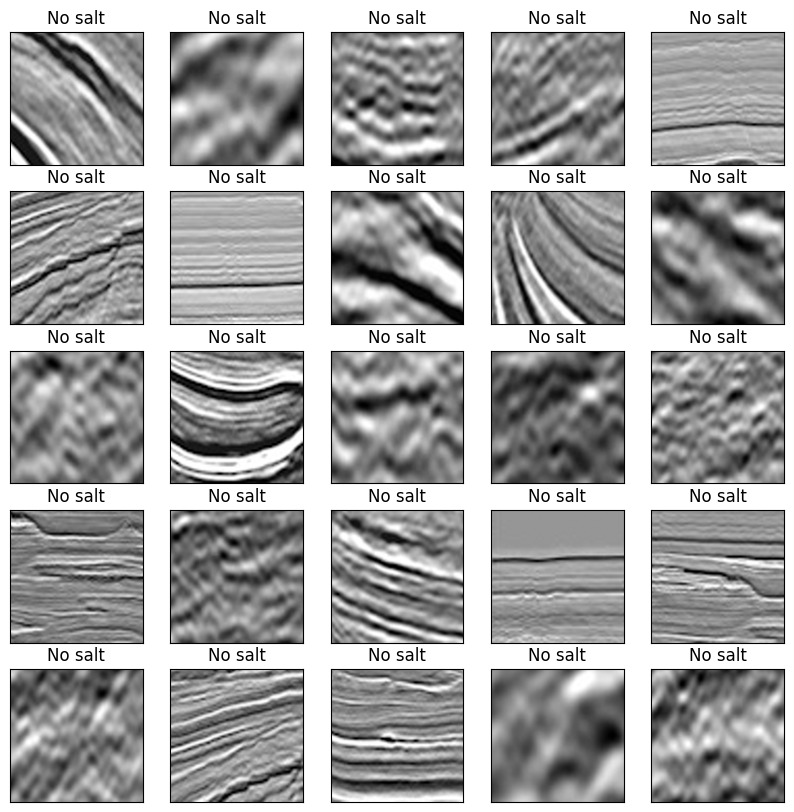

In [5]:
# Create a 5x5 grid of subplots (total 25 training examples)
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

k = 0  # Patch index

# Loop over rows and columns of the subplot grid
for n in range(5):
    for m in range(5):
        # Show the k-th patch as a grayscale image
        axs[n, m].imshow(X_train[k, :, :, 0],
                         interpolation='spline16',
                         cmap=plt.cm.gray,
                         aspect=1)

        # Remove axis ticks for cleaner visualization
        axs[n, m].set_xticks([])
        axs[n, m].set_yticks([])

        # Display the class label as the title of the subplot
        if y_train[k, 0] == 1:
            axs[n, m].set_title('Salt')
        else:
            axs[n, m].set_title('No salt')

        k += 1  # Move to next patch


What do you notice?

*   Is it an easy task?
*   Could you predict the labels?

Let's see if it will work...



## Training ##
To train our first model, we need to define its architecture. A typical deep convolution neural network for image classification would look something like this:

In [6]:
# Define a CNN for binary classification of seismic image patches
model = Sequential([
    # Convolutional layer: 16 filters, 3x3 kernel, same padding, ReLU activation
    Conv2D(16, 3, padding='same', activation='relu', input_shape=dim),

    # Downsampling with max pooling (2x2)
    MaxPooling2D(),

    # Dropout to prevent overfitting
    Dropout(0.2),

    # Second convolutional layer: 32 filters
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),

    # Third convolutional layer: 64 filters
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),

    # Flatten 3D feature maps into 1D vector for dense layers
    Flatten(),

    # Fully connected dense layer with 512 units and ReLU activation
    Dense(512, activation='relu'),

    # Output layer: 2 units for binary classification, softmax to get probabilities
    Dense(2, activation='softmax')
])

# Compile the model with:
# - Adam optimizer (adaptive learning rate)
# - Binary crossentropy loss for two-class classification
# - Track binary accuracy metric
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# Print a summary of the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,986 (8.09 MB)

 Trainable params: 2,121,986 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

Now you can train your first convolutional neural net:

In [7]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=10)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - binary_accuracy: 0.9219 - loss: 0.2831 - val_binary_accuracy: 0.9510 - val_loss: 0.2511
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9217 - loss: 0.2720 - val_binary_accuracy: 0.9510 - val_loss: 0.2073
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9321 - loss: 0.1983 - val_binary_accuracy: 0.9520 - val_loss: 0.2124
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9408 - loss: 0.1649 - val_binary_accuracy: 0.9430 - val_loss: 0.1549
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9508 - loss: 0.1414 - val_binary_accuracy: 0.9340 - val_loss: 0.2199
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9629 - loss: 0.1078 - val_binary_accuracy: 0.9580 - val_loss: 0.1299
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9684 - loss: 0.0909 - val_binary_accuracy: 0.9590 - val_loss: 0.1225
Epoc

To visualize our training, you can plot learning curves:

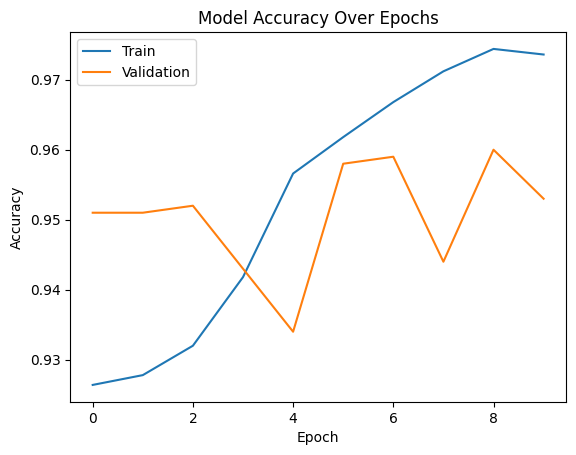

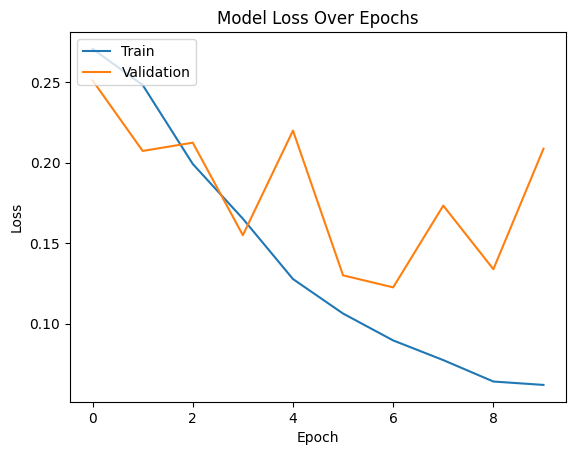

In [8]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['binary_accuracy'])         # Training accuracy
plt.plot(history.history['val_binary_accuracy'])     # Validation accuracy
plt.title('Model Accuracy Over Epochs')              # Title of the plot
plt.ylabel('Accuracy')                               # Y-axis label
plt.xlabel('Epoch')                                  # X-axis label
plt.legend(['Train', 'Validation'], loc='upper left')# Legend
plt.show()                                           # Show the accuracy plot

# Plot training and validation loss over epochs
plt.plot(history.history['loss'])                    # Training loss
plt.plot(history.history['val_loss'])                # Validation loss
plt.title('Model Loss Over Epochs')                  # Title of the plot
plt.ylabel('Loss')                                   # Y-axis label
plt.xlabel('Epoch')                                  # X-axis label
plt.legend(['Train', 'Validation'], loc='upper left')# Legend
plt.show()                                           # Show the loss plot

and a confusion matrix:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


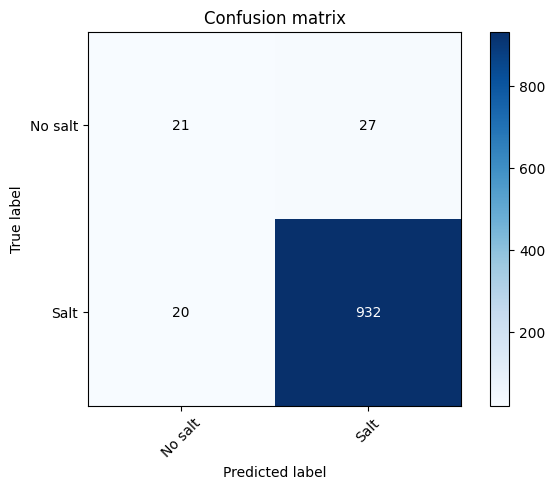

In [17]:
# ---- Function to plot the confusion matrix ----
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# ---- Prepare labels and predictions for confusion matrix ----

# Convert one-hot encoded true labels to class indices (0 or 1)
y_true_classes = np.argmax(y_val, axis=1)

# Predict on validation set and convert softmax probabilities to class indices
y_pred_probs = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plot_confusion_matrix(cm, ['No salt', 'Salt'])


##Application##
Finally, we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image. Because we have to predict the label of each pixel in the image, this takes a while (~4 mins)

99

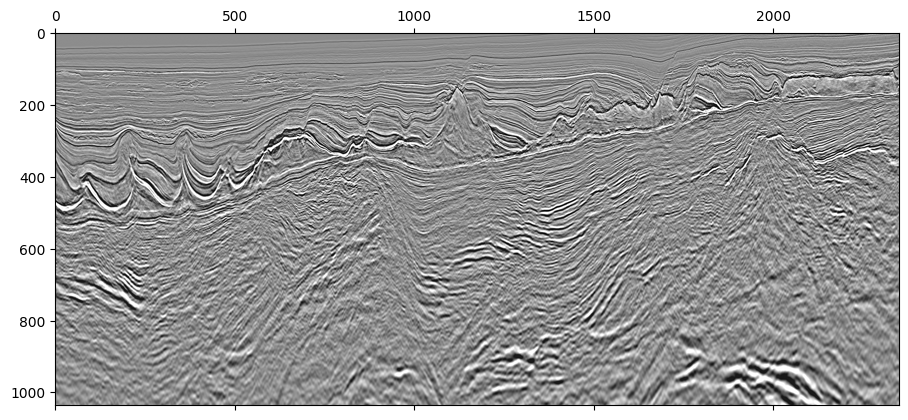

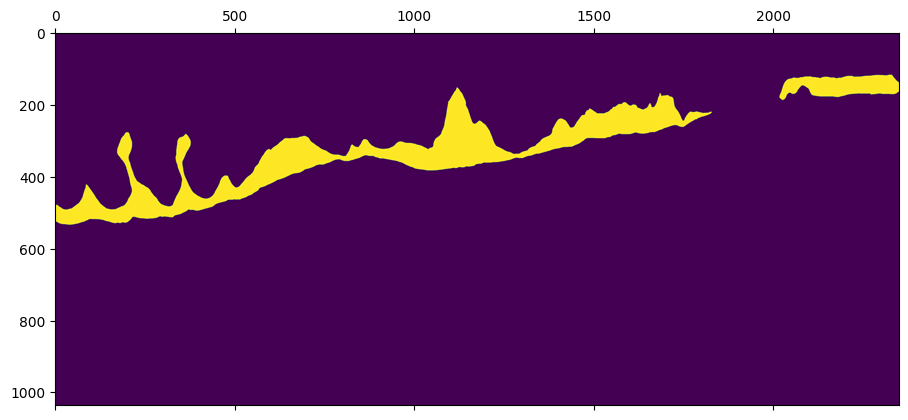

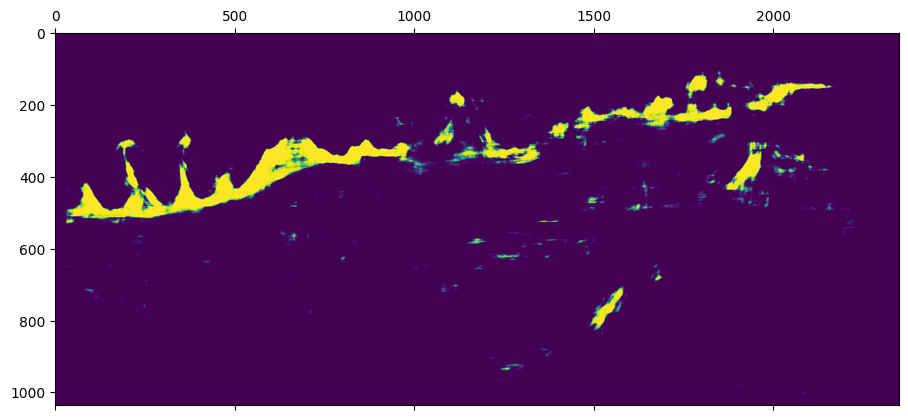

In [12]:
# Get dimensions of the full seismic section
(t_max, x_max, _) = data.shape

# Preallocate the result array to hold model output for each pixel (2 classes: salt/no salt)
result = np.zeros((t_max, x_max, 2))

# Preallocate a batch array to hold input patches during inference
# The number of time steps is (t_max - dim[1]) because we slide a window vertically
batch = np.zeros((t_max - dim[1], *dim))  # Shape: (num_patches, height, width, 1)

# Initialize progress tracker and batch index
m = 0
n = 0

# Loop over the spatial (x) dimension, leaving out the edges to avoid going out of bounds
for x in range(dim[0] // 2, x_max - dim[0] // 2):
    # Display progress in the console
    stdout.write("\r%d" % m)
    stdout.flush()
    m += 100 / (x_max - dim[0])

    # For each x, slide a window across the time (t) axis
    for t in range(dim[1] // 2, t_max - dim[1] // 2):
        # Extract a patch centered at (t, x)
        batch[n, :, :, 0] = data[t - dim[1] // 2 : t + dim[1] // 2,
                                 x - dim[0] // 2 : x + dim[0] // 2, 0]
        n += 1

    # Predict class probabilities for the entire vertical column at x using the batch
    result[dim[1] // 2 : t_max - dim[1] // 2, x, :] = model.predict_on_batch(batch)

    # Reset batch index for next x-column
    n = 0

# ---------- Visualization ----------
# Show original seismic image
plt.matshow(data[:, :, 0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)

# Show ground truth mask
plt.matshow(mask, interpolation='spline16', aspect=1)

# Show model predictions (only the 'salt' probability channel)
plt.matshow(result[:, :, 0], interpolation='spline16', aspect=1)

plt.show()

Excellent! Your first model is already able to recognize most of the salt in the seismic section. If you want to know how to improve the prediction in terms of speed and accuracy, check out [tutorial-2](https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-2/tutorial_2.ipynb)